# **DATA SCIENTIST PROJECT**

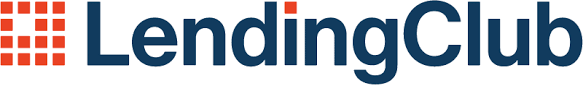

Lending Club es una compañía estadounidense de préstamo entre particulares, con sede en San Francisco.

Este dataset contiene datos para todos los préstamos emitidos durante el período 2007-2011, incluido el estado actual del préstamo (actual, cancelado, totalmente pagado, etc.) y la información de pago más reciente.

**Objetivo:**

Encuentrar el modelo y su conjunto de hiperparámetros que mejor predigan si un crédito tiene o no riesgo. Se trata de conseguir un modelo que sirva para predecir si un cliente, en base a ciertas características, es adecuado para que adquiera el producto financiero.

Target/Objetivo de predicción:
* **bad_loans**: (+1 significa crédito riesgo, 0 es seguro)

## Funciones Predefinidas

In [198]:
import warnings
warnings.filterwarnings('ignore')

In [199]:
# Hacer print con el texto en negrita
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [200]:
# Creamos una función que imprime por pantalla características importantes de los datos
def inspect_data(df):
    printmd('Data Shape')
    print(df.shape)
    print('\n')
    printmd('Missing Values: ')
    print(df.isnull().sum())
    print('\n')
    printmd('Data Types: ')
    print(df.dtypes)

In [201]:
def plottingRegressComparison(yreal,ypred):

    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})

    i=min(ypred)
    comparison["line"] = [i+j*max(yreal)/len(comparison) for j in range(len(comparison))]
    comparison["line2"] = comparison["line"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison.plot(x="line", y="line2", ax=ax, color="red", marker="*", markersize=2)
    comparison.plot.scatter(x="yreal", y="ypred", ax=ax)
    ax.grid(True)
    ax.set_yticklabels(ax.get_yticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_xticklabels(ax.get_xticks(minor=False), fontname='Serif', fontsize=10)
    ax.set_ylabel("Ventas predichas", fontname='Serif', fontsize=10)
    ax.set_xlabel("Ventas reales", fontname='Serif', fontsize=10)
    ax.set_title("Ventas reales VS Ventas predichas", fontname='Serif', fontsize=10)
    ax.get_legend().remove()

In [202]:
def plottingResults(yreal,ypred):
    # Creamos
    comparison = pd.DataFrame({"yreal":yreal, "ypred":ypred})
    comparison["diff"] = comparison["yreal"] - comparison["ypred"]

    fig, ax = plt.subplots(figsize=(8,8))
    comparison["diff"].hist(bins=100, ax=ax)
    ax.set_xticklabels(ax.get_xticks(),fontsize=10, rotation=45)
    ax.set_yticklabels(ax.get_yticks(),fontsize=10)
    ax.set_xlabel("Error", fontname='Serif', fontsize=10)
    ax.set_title("Histograma del error de predicción", fontname='Serif', fontsize=16)

# Funciones de Preprocesamiento

## Missing data

In [203]:
def meanValueImputation(data, feature):
    """
    Completa los valores vacíos en una columna de un DataFrame con el valor medio de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor medio de la columna
    valor_medio = data[feature].mean()

    # Completa los valores vacíos con el valor medio
    data[feature].fillna(valor_medio, inplace=True)

In [204]:
from scipy import stats
def modeValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna de un DataFrame con el valor moda de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor moda de la columna
    valor_moda = stats.mode(data[feature])[0][0]

    # Completa los valores vacíos con el valor moda
    data[feature].fillna(valor_moda, inplace=True)

In [205]:
def mostCommonValueImputation(data, feature):

    """
    Completa los valores vacíos en una columna categórica de un DataFrame con el valor más común (modo) de esa columna.

    :param data: DataFrame en el que se encuentra la columna.
    :param columna: Nombre de la columna que se desea completar.
    """
    # Calcula el valor más común (modo) de la columna
    valor_mas_comun = data[feature].mode()[0]

    # Completa los valores vacíos con el valor más común
    data[feature].fillna(valor_mas_comun, inplace=True)

## Outliers

In [206]:
def statisticalOutlierDetection(data, feature, thresholdmin=None,thresholdmax=None, drop=False):
  #Eliminamos outliers en base a un criterio estadístico
  if thresholdmax:
    print("dentro")
    data_clean = data.drop(data[data[feature]>=thresholdmax].index)
  else:
    data_clean = data.copy()

  if thresholdmin:
    data_clean = data_clean.drop(data_clean[data_clean[feature]<=thresholdmin].index)
  else:
    data_clean = data_clean.copy()

  data_clean.reset_index(drop=True, inplace=True)

  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))
  print(data_clean.shape)

  if drop==True:
    return data_clean
  else:
    return data

In [207]:
def modelOutlierDetection(data, nf, n = 20, drop = False):
  ## LocalOutlierFactor: se basa en la idea de que las instancias de datos anómalas tienen una densidad de puntos diferente a la de las instancias de datos normales en su vecindario local.
  from sklearn.neighbors import LocalOutlierFactor
  # Creamos el objeto LOF y ajustamos los datos
  clf = LocalOutlierFactor(n_neighbors=n)  # número de vecinos más cercanos que se considerarán al calcular la densidad local de un punto de datos.
  y_pred = clf.fit_predict(np.array(nf))
  # Eliminamos los outliers de nuestro set de datos
  data_clean = data.copy()
  data_clean["outliers"] = y_pred
  data_clean.drop(data_clean[data_clean["outliers"]<0].index, inplace=True)
  data_clean.drop("outliers", axis=1, inplace=True)
  data_clean.reset_index(drop=True, inplace=True)
  print("Se han eliminado : {} instancias.".format(len(data)-len(data_clean)))

  if drop:
    return  data_clean
  else:
    return data

## Codificación

In [208]:
from sklearn.preprocessing import LabelEncoder
def labelEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  le = LabelEncoder()
  data_cod = data.copy() # Creo un dataframe de plantilla porque no quiero modificar el original
  for col in categorical_features.columns:
      data_cod[col+"_cod"]=le.fit_transform(np.array(data_cod[col]))

  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [209]:
from sklearn.preprocessing import OneHotEncoder
def OHEncoding(data, categorical_features):
  ohe = OneHotEncoder()
  data_cod = data.copy()
  for col in categorical_features.columns:
    # Data a codificar
    X = np.array(data_cod[[col]])
    # Fit & transform
    ohe.fit(X)
    Xohe = ohe.transform(X).toarray()
    # Unimos al set de datos de partida
    dataohe = pd.DataFrame(Xohe, columns=data_cod[col].drop_duplicates().tolist())
    data_cod = pd.concat([data_cod,dataohe], axis=1)

  # Eliminamos las variables originales de nuestro set de datos
  data_cod = data_cod.drop(categorical_features.columns, axis=1)

  return data_cod

In [210]:
!pip install category_encoders
import category_encoders as ce
def binaryEncoding(data, categorical_features):
  # Defino mi modelo de codificación
  data_cod = data.copy()
  # Creamos el objeto BinaryEncoder y ajustamos el dataframe
  encoder = ce.BinaryEncoder(cols=categorical_features)
  data_cod = encoder.fit_transform(data_cod)
  data_cod

  return data_cod

## -------------------

### Carga y Previsualización de Datos

In [211]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [212]:
df = pd.read_csv("/workspaces/Data_Scientist_Project/data/challenge-lending_club_data_train.csv")
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


### Primer Análisis de Cada Variable

In [213]:
columns = df.columns
columns.unique()

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

In [214]:
for i in columns:
  print(df[i].head(2))

0    1077501
1    1077430
Name: id, dtype: int64
0    1296599
1    1314167
Name: member_id, dtype: int64
0    5000
1    2500
Name: loan_amnt, dtype: int64
0    5000
1    2500
Name: funded_amnt, dtype: int64
0    4975
1    2500
Name: funded_amnt_inv, dtype: int64
0     36 months
1     60 months
Name: term, dtype: object
0    10.65
1    15.27
Name: int_rate, dtype: float64
0    162.87
1     59.83
Name: installment, dtype: float64
0    B
1    C
Name: grade, dtype: object
0    B2
1    C4
Name: sub_grade, dtype: object
0      NaN
1    Ryder
Name: emp_title, dtype: object
0    10+ years
1     < 1 year
Name: emp_length, dtype: object
0    RENT
1    RENT
Name: home_ownership, dtype: object
0    24000.0
1    30000.0
Name: annual_inc, dtype: float64
0           Verified
1    Source Verified
Name: is_inc_v, dtype: object
0    20111201T000000
1    20111201T000000
Name: issue_d, dtype: object
0     Fully Paid
1    Charged Off
Name: loan_status, dtype: object
0    n
1    n
Name: pymnt_plan, dtype: o

In [215]:
variable = df['short_emp']
variable.unique()

array([0, 1])

In [216]:
variable = df['pymnt_plan']
variable.unique()

array(['n'], dtype=object)

In [217]:
variable = df['initial_list_status']
variable.unique()

array(['f', 'w'], dtype=object)

In [218]:
variable = df['mths_since_last_major_derog']
variable.unique()

array([ nan,  69.,  62.,  74.,  10.,  27.,  56.,  61.,  34.,  25.,  46.,
        63.,  48.,  57.,  68.,  60.,  65.,  30.,  41.,  71.,  16.,  73.,
        75.,  45.,  33.,  13.,   5.,  64.,  21.,  50.,  44.,  38.,  59.,
        47.,  29.,  52.,  39.,  24.,  94.,  37.,  79.,  66.,  35.,  11.,
        58.,  19.,  67.,  17.,  31.,   1.,  76.,  84.,  70.,   8.,  20.,
        22.,  42.,   7.,  18.,  54.,  36.,  43.,  55.,  40.,   2.,  77.,
        72.,  14.,  15.,   4.,   3.,  51.,  53.,  23., 100.,  12.,  49.,
       102.,  80.,   9.,  28.,  78.,  81.,  26., 152.,  92.,  88.,   6.,
        32.,  82.,  83.,  87.,   0.,  91.,  89.,  86., 122., 101., 113.,
        96., 139., 109.,  90., 148.])

In [219]:
variable = df['inactive_loans']
variable.unique()

array([1])

In [220]:
variable = df['emp_length'] #me quedo con emp_length_num
variable.unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years',
       nan], dtype=object)

In [221]:
variable = df['grade'] #me quedo con grade_num
variable.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [222]:
variable = df['last_major_derog_none']
variable.unique()

array([1, 0])

In [223]:
variable = df['delinq_2yrs_zero'] #similar a delinq_2yrs
variable.unique()

array([ 1.,  0., nan])

In [224]:
variable = df['pub_rec'] #similar a pub_rec_zero 
variable.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan,  6., 10.,  7.])

A primera vista, voy a eliminar las siguientes columnas que considero irrelevantes: 

- desc (descripción)
- earliest_cr_line (fecha)
- emp_lenght (igual que emp_lenght_num)
- grade (igual que grade_num)
- id (índice)
- issue_d (fecha)
- last_credit_pull_d (fecha)
- last_pymnt_d (fecha)
- member_id (id)
- mths_since_last_delinq (fecha)
- mths_since_last_record (fecha)
- next_pymnt_d (fecha)
- pymnt_plan (array(['n']))
- sub_grade (igual que sub_grade_num)
- title
- url
- zip_code
- inactive_loans (array([1]))
- delinq_2yrs_zero (igual que delinq_2yrs)
- pub_rec_zero (igual que pub_rec)
- collections_12_mths_zero
- short_emp	(sin información, solo contiene 0 y 1)
- final_d	(columna de fecha)
- last_record_none (sin información)
- last_major_derog_none	(similar a last_delinq_none)
- policy_code (solo tiene 1 valor)


### Segundo Análisis de Cada Variable

**- Columnas Restantes:** addr_state, annual_inc, collection_recovery_fee, collections_12_mths_ex_med, delinq_2yrs, dti, emp_title, funded_amnt, funded_amnt_inv, home_ownership, initial_list_status, inq_last_6mths, installment, int_rate, last_pymnt_amnt, loan_amnt, loan_status, mths_since_last_major_derog, open_acc, out_prncp, out_prncp_inv, pub_rec, purpose, recoveries, revol_bal, revol_util, term, total_acc, total_pymnt, total_pymnt_inv, total_rec_int, total_rec_late_fee, is_inq_v, not_compliant, status, bad_loans, emp_length_num, grade_num, sub_grade_num, payment_inc_ratio, last_delinq_none

In [225]:
df = df[['addr_state', 'annual_inc', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'emp_title', 'funded_amnt',
         'funded_amnt_inv', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'last_pymnt_amnt', 
         'loan_amnt', 'loan_status', 'mths_since_last_major_derog', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec', 
         'purpose', 'recoveries', 'revol_bal', 'revol_util', 'term', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 
         'not_compliant', 'status', 'bad_loans', 'emp_length_num', 'grade_num', 'sub_grade_num', 'payment_inc_ratio', 'last_delinq_none']]

In [226]:
df.head(3)

,addr_state,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,emp_title,funded_amnt,funded_amnt_inv,home_ownership,...,total_rec_int,total_rec_late_fee,not_compliant,status,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
0,AZ,24000.0,0.00,0.0,0.0,27.65,NaN,5000,4975,RENT,...,861.07,0.0,0,Fully Paid,0,11,5,0.4,8.14350,1
1,GA,30000.0,1.11,0.0,0.0,1.00,Ryder,2500,2500,RENT,...,435.17,0.0,0,Charged Off,1,1,4,0.8,2.39320,1
2,IL,12252.0,0.00,0.0,0.0,8.72,NaN,2400,2400,RENT,...,603.65,0.0,0,Fully Paid,0,11,4,1.0,8.25955,1


**- Variables Categoricas:**

In [227]:
categorical_features = df.select_dtypes(include=[object])
categorical_features.head(2)

,addr_state,emp_title,home_ownership,initial_list_status,loan_status,purpose,term,status
0,AZ,NaN,RENT,f,Fully Paid,credit_card,36 months,Fully Paid
1,GA,Ryder,RENT,f,Charged Off,car,60 months,Charged Off


In [228]:
categorical_features.apply(lambda x : len(x.unique()))

addr_state                50
emp_title              54463
home_ownership             4
initial_list_status        2
loan_status                5
purpose                   12
term                       2
status                     3
dtype: int64

In [229]:
variable = df['addr_state']
variable.unique()

array(['AZ', 'GA', 'IL', 'CA', 'TX', 'VA', 'MO', 'CT', 'UT', 'FL', 'NY',
       'PA', 'MN', 'NJ', 'OR', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA', 'WA',
       'WI', 'AL', 'NV', 'CO', 'MD', 'WV', 'VT', 'MI', 'DC', 'SD', 'NC',
       'AR', 'KS', 'NM', 'HI', 'AK', 'OK', 'MT', 'WY', 'NH', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME'], dtype=object)

In [230]:
variable = df['emp_title']
variable.unique()

array([nan, 'Ryder', 'AIR RESOURCES BOARD', ...,
       'Douglas County Highway Department', 'FRITOLAY',
       'Pacific University'], dtype=object)

**Elimino** el titulo del empleo y la dirección del estado, ya que tienen muchos valores unicos, lo cual requiere más recursos computacionales

In [231]:
drop_columns = ['addr_state', 'emp_title']
df = df.drop(drop_columns, axis=1)

In [232]:
categorical_features = df.select_dtypes(include=[object])
categorical_features.head(2)

,home_ownership,initial_list_status,loan_status,purpose,term,status
0,RENT,f,Fully Paid,credit_card,36 months,Fully Paid
1,RENT,f,Charged Off,car,60 months,Charged Off


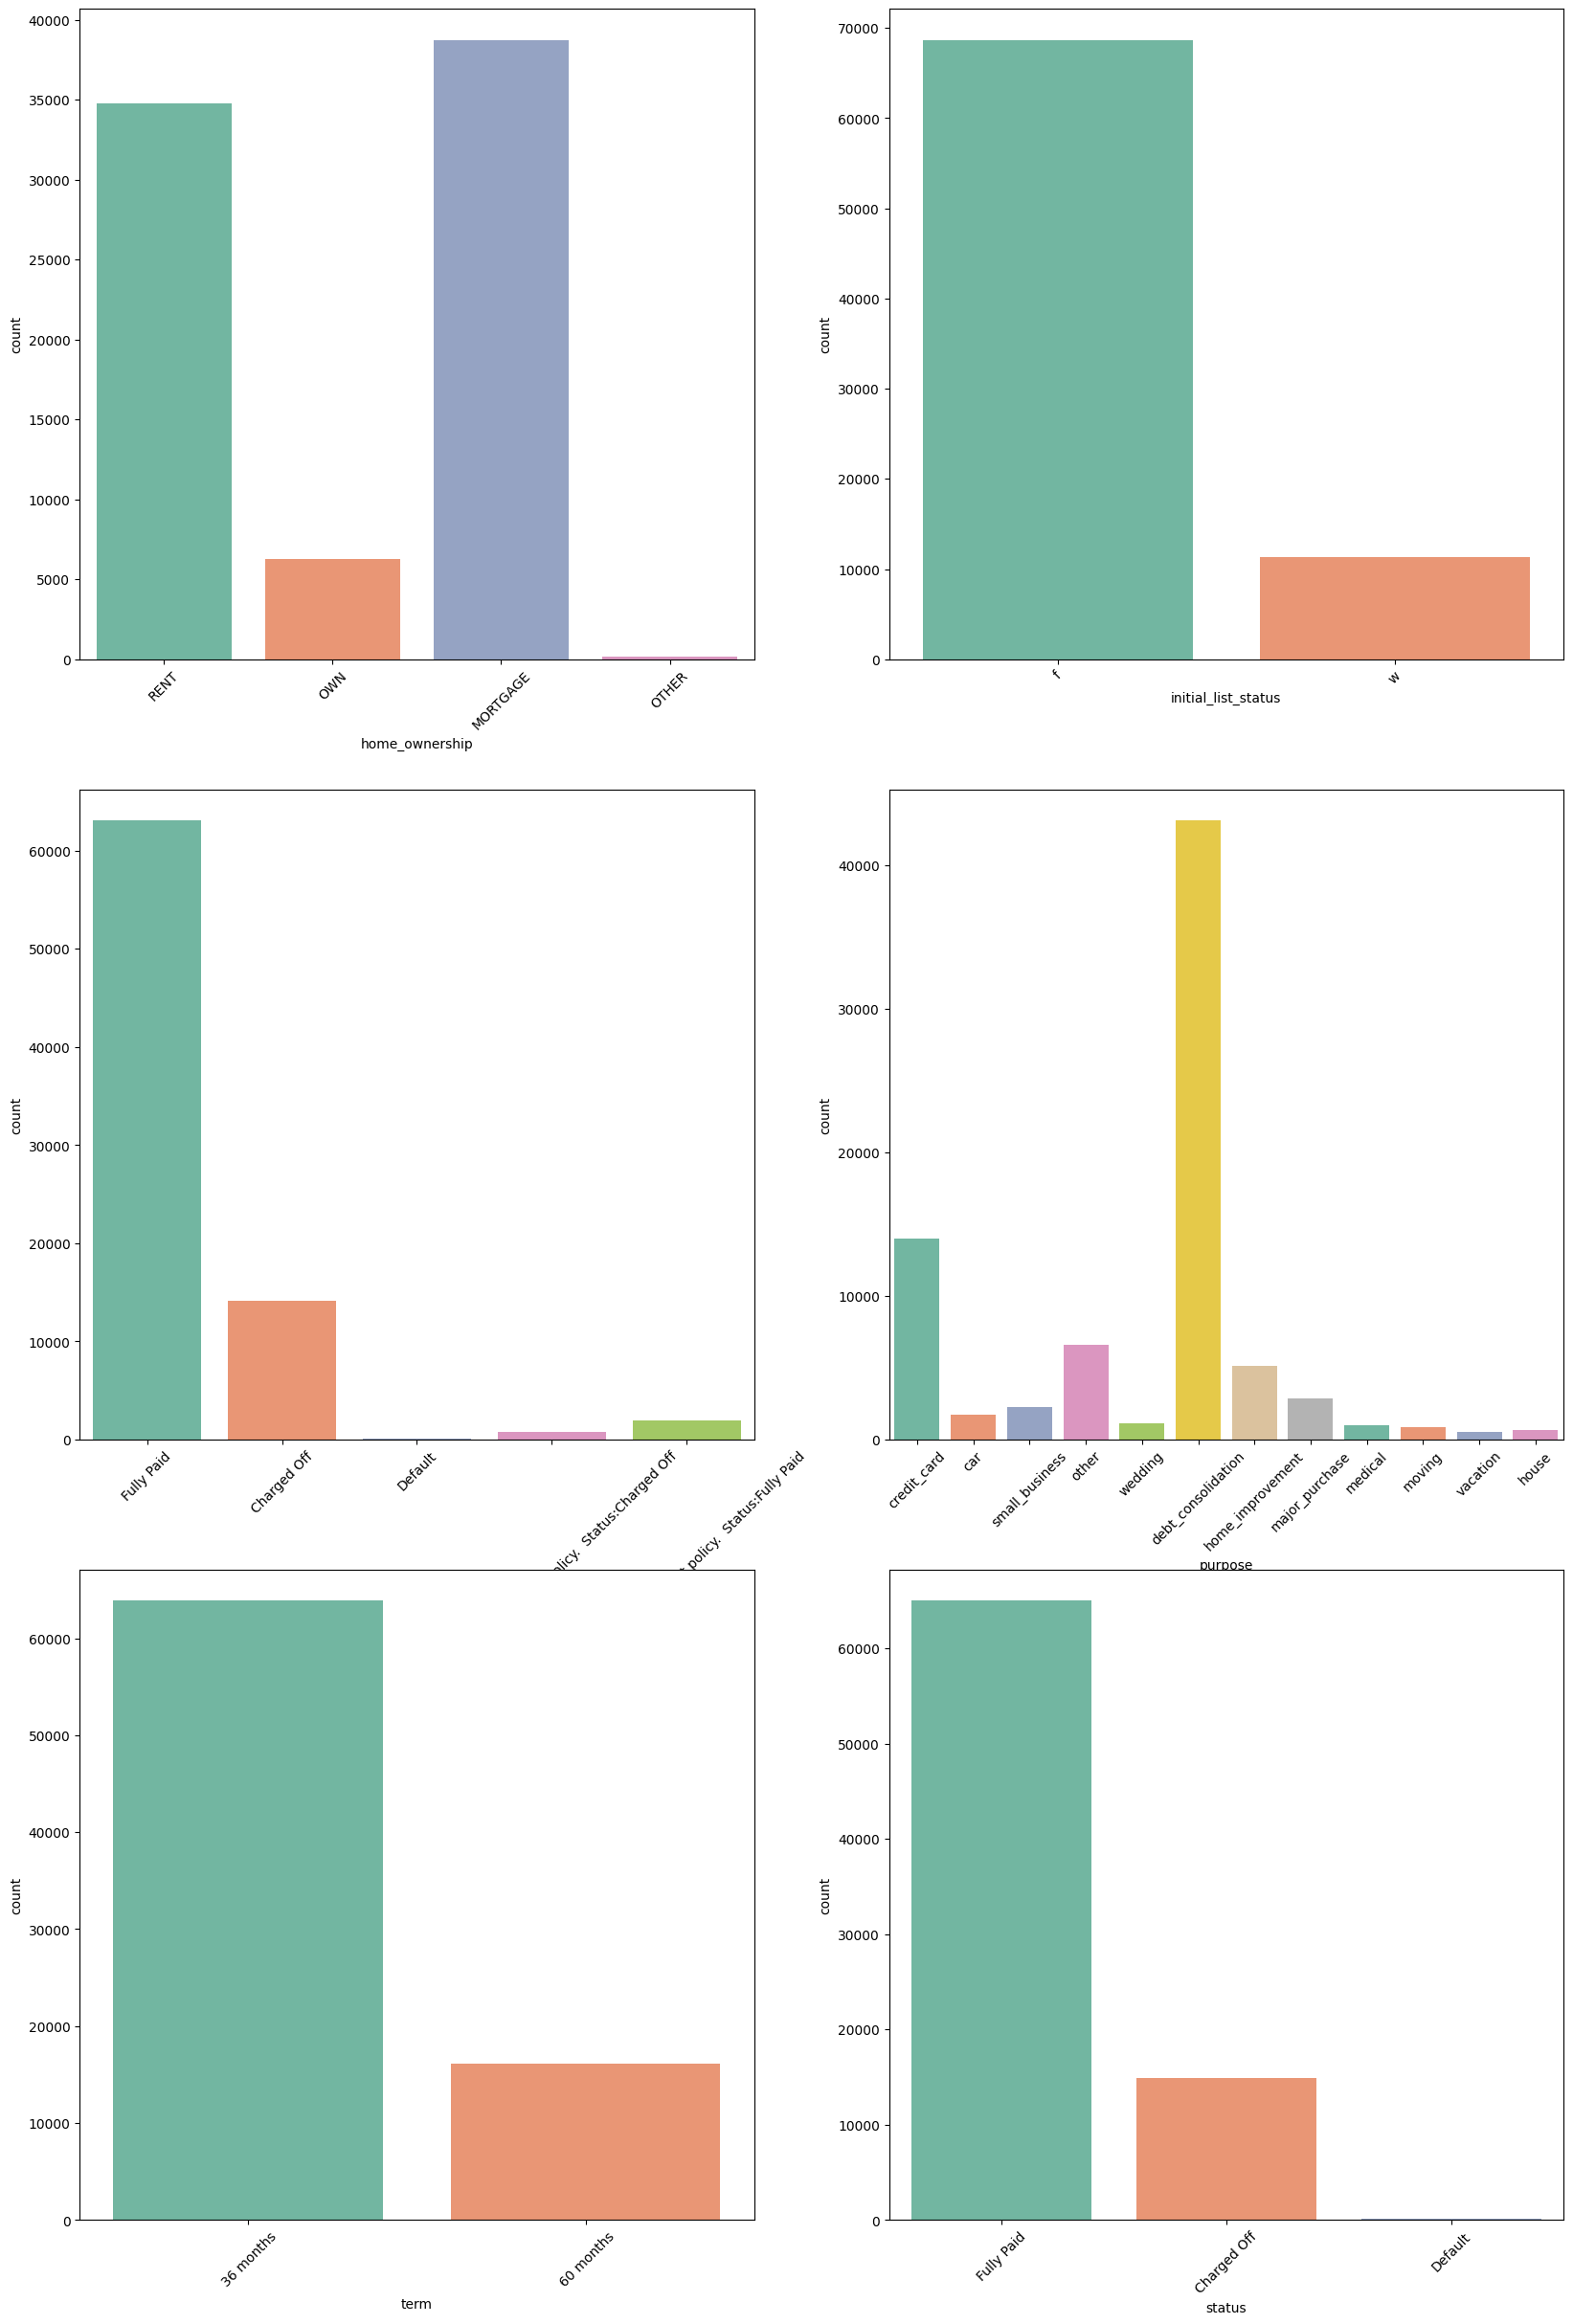

In [233]:
fig, axs = plt.subplots(3, 2, figsize=(20,30))
catdata = categorical_features.columns
for col, ax in zip(catdata, axs.ravel()):
    sns.countplot(x=col,data=df,palette='Set2',ax=ax)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

- Variables Numéricas

In [234]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.head(2)

,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,...,total_pymnt_inv,total_rec_int,total_rec_late_fee,not_compliant,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
0,24000.0,0.00,0.0,0.0,27.65,5000,4975,1.0,162.87,10.65,...,5831.78,861.07,0.0,0,0,11,5,0.4,8.1435,1
1,30000.0,1.11,0.0,0.0,1.00,2500,2500,5.0,59.83,15.27,...,1008.71,435.17,0.0,0,1,1,4,0.8,2.3932,1


In [235]:
numerical_features.apply(lambda x : len(x.unique()))

annual_inc                      8375
collection_recovery_fee         4928
collections_12_mths_ex_med         4
delinq_2yrs                       17
dti                             3476
funded_amnt                     1149
funded_amnt_inv                 6813
inq_last_6mths                    29
installment                    25156
int_rate                         464
last_pymnt_amnt                69009
loan_amnt                       1107
mths_since_last_major_derog      104
open_acc                          52
out_prncp                        111
out_prncp_inv                    111
pub_rec                           10
recoveries                      7219
revol_bal                      31977
revol_util                      1144
total_acc                         86
total_pymnt                    73838
total_pymnt_inv                74129
total_rec_int                  70730
total_rec_late_fee              2022
not_compliant                      2
bad_loans                          2
e

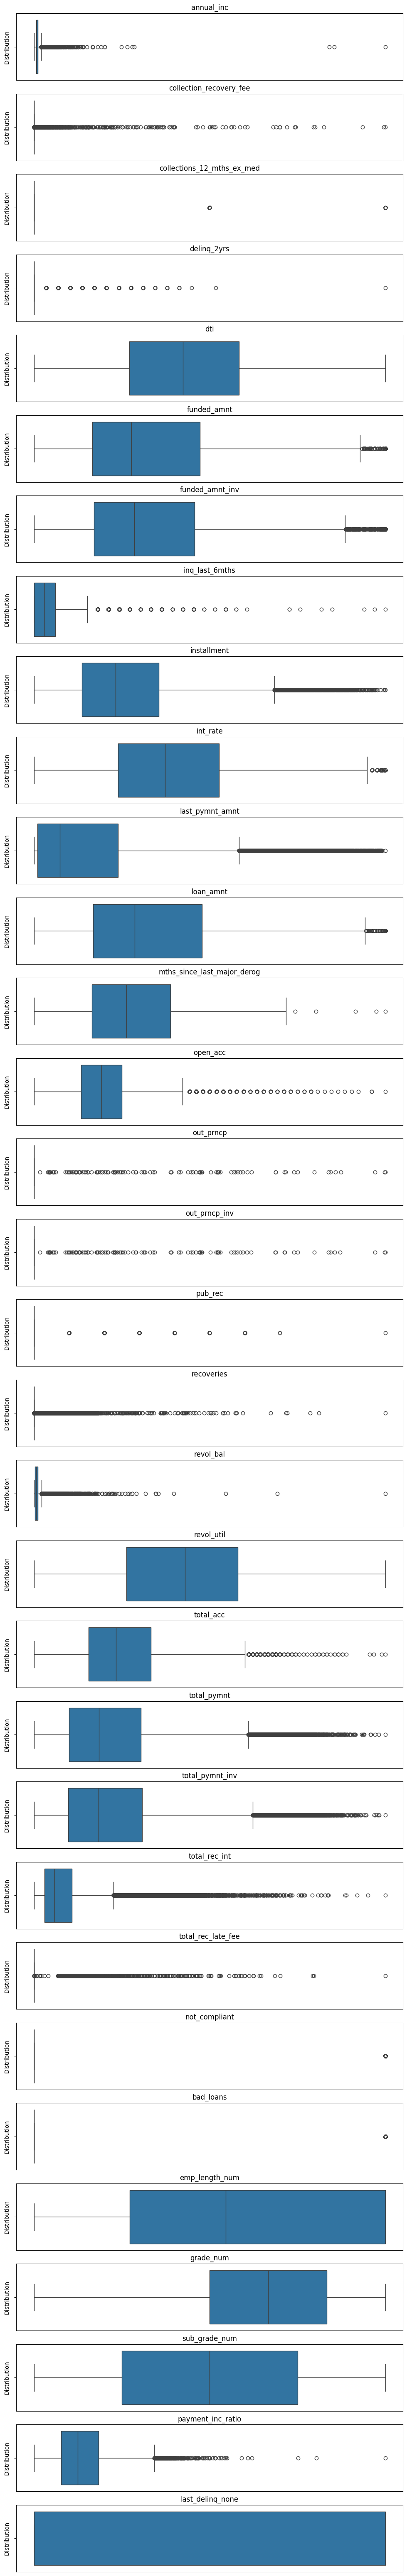

In [236]:
cols = numerical_features.columns
fig, axs = plt.subplots(len(cols),1,figsize=(12,80))

for col, ax in zip(cols, axs.ravel()):
  sns.boxplot(x=col, data=numerical_features, ax=ax)
  ax.set_ylabel("Distribution")
  ax.get_xaxis().set_visible(False)
  ax.set_title(col)

In [237]:
variable = df['collections_12_mths_ex_med']
variable.unique()

array([ 0., nan,  1.,  2.])

In [238]:
variable = df['delinq_2yrs']
variable.unique()

array([ 0.,  2.,  3.,  1.,  4.,  6.,  5.,  8.,  7.,  9., 11., nan, 13.,
       10., 15., 12., 29.])

In [239]:
variable = df['pub_rec']
variable.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan,  6., 10.,  7.])

In [240]:
correlacion_pearson = numerical_features.corr(method='pearson')
correlacion_pearson

,annual_inc,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,funded_amnt,funded_amnt_inv,inq_last_6mths,installment,int_rate,...,total_pymnt_inv,total_rec_int,total_rec_late_fee,not_compliant,bad_loans,emp_length_num,grade_num,sub_grade_num,payment_inc_ratio,last_delinq_none
annual_inc,1.000000,0.007423,0.007473,0.045637,-0.136117,0.285865,0.275348,0.044869,0.288236,0.001164,...,0.264797,0.181753,0.003255,-0.000320,-0.053146,0.107879,-0.003589,0.002757,-0.243942,-0.047556
collection_recovery_fee,0.007423,1.000000,-0.002256,0.004142,-0.003370,0.027710,0.015345,0.027450,0.032018,0.022640,...,-0.007820,0.010427,0.081958,0.037248,0.117320,-0.005711,-0.042042,0.000169,0.026474,-0.010794
collections_12_mths_ex_med,0.007473,-0.002256,1.000000,0.030298,0.007736,0.007171,0.009217,-0.006019,0.012783,0.046710,...,0.008900,0.003811,-0.003180,-0.008869,-0.000981,0.005207,-0.033926,0.001963,0.002423,-0.024820
delinq_2yrs,0.045637,0.004142,0.030298,1.000000,-0.006899,0.013492,0.013026,0.018539,0.025645,0.119927,...,0.003333,0.022628,0.015593,0.011284,0.016611,0.031105,-0.113433,-0.001902,-0.039204,-0.385806
dti,-0.136117,-0.003370,0.007736,-0.006899,1.000000,0.093661,0.105728,0.001108,0.096194,0.203816,...,0.037137,0.079163,-0.024677,-0.021896,0.116723,0.067301,-0.145447,0.015741,0.226112,0.017859
funded_amnt,0.285865,0.027710,0.007171,0.013492,0.093661,1.000000,0.976209,-0.011205,0.963268,0.248331,...,0.817508,0.689502,0.012260,-0.085679,0.067068,0.163903,-0.201581,0.033304,0.542826,0.007658
funded_amnt_inv,0.275348,0.015345,0.009217,0.013026,0.105728,0.976209,1.000000,-0.038084,0.936891,0.253413,...,0.838887,0.667216,-0.008882,-0.139536,0.057027,0.173610,-0.180557,0.031775,0.524703,0.022802
inq_last_6mths,0.044869,0.027450,-0.006019,0.018539,0.001108,-0.011205,-0.038084,1.000000,0.003604,0.184540,...,-0.050639,0.035752,0.055773,0.433491,0.078397,-0.018561,-0.232039,0.023577,-0.052018,-0.051815
installment,0.288236,0.032018,0.012783,0.025645,0.096194,0.963268,0.936891,0.003604,1.000000,0.239376,...,0.794928,0.638529,0.018699,-0.072087,0.050098,0.149004,-0.189685,0.025081,0.579221,-0.011877
int_rate,0.001164,0.022640,0.046710,0.119927,0.203816,0.248331,0.253413,0.184540,0.239376,1.000000,...,0.137782,0.386164,0.031918,0.026591,0.244784,0.042570,-0.920855,0.038010,0.222730,-0.173128


In [241]:
umbral = 0.5
columnas_altamente_correlacionadas = set()

for i in range(len(correlacion_pearson.columns)):
    for j in range(i):
        if abs(correlacion_pearson.iloc[i, j]) > umbral:
            colname = correlacion_pearson.columns[i]
            columnas_altamente_correlacionadas.add(colname)

In [242]:
columnas_altamente_correlacionadas

{'funded_amnt_inv',
 'grade_num',
 'installment',
 'last_pymnt_amnt',
 'loan_amnt',
 'out_prncp_inv',
 'payment_inc_ratio',
 'recoveries',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int'}

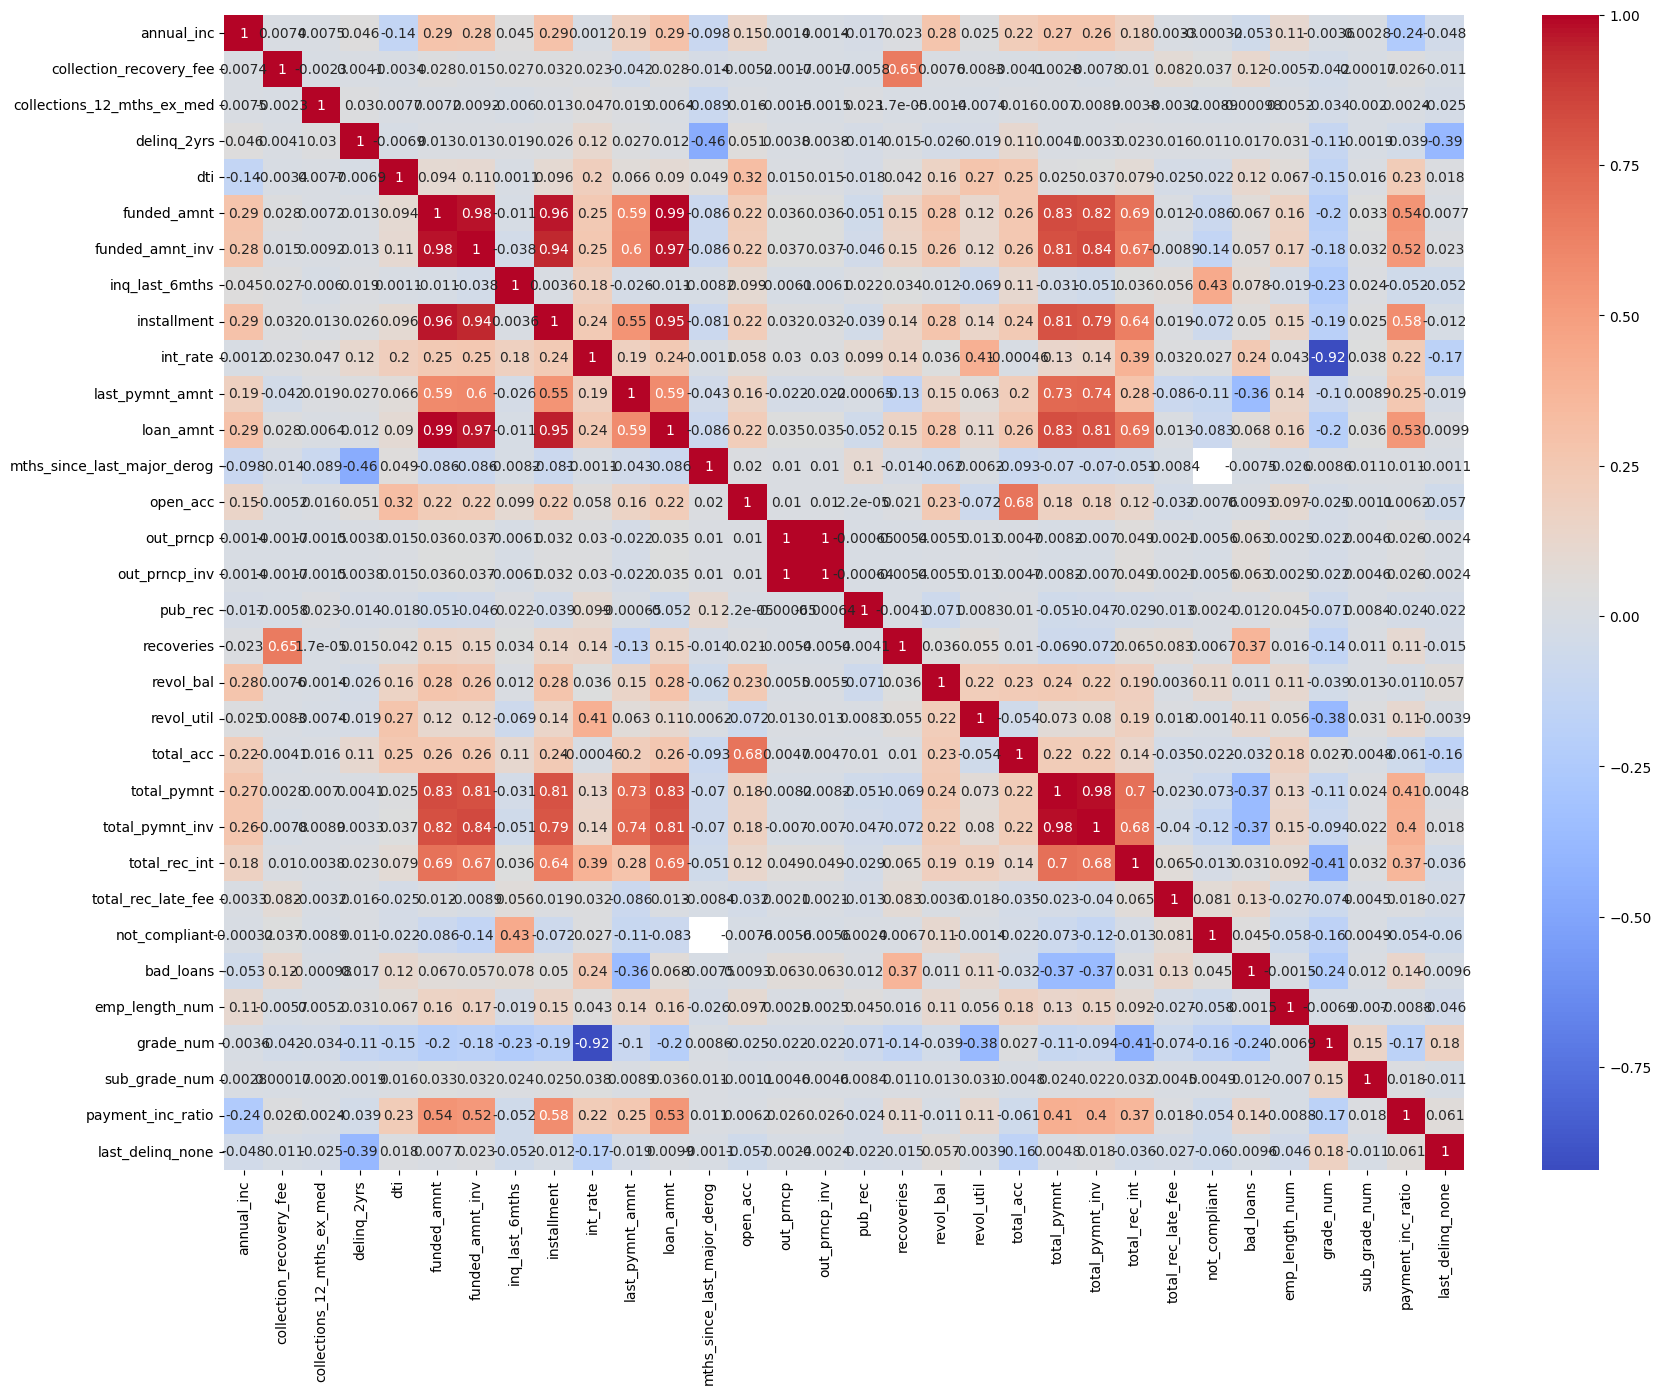

In [248]:
matriz_correlacion = numerical_features.corr()
plt.figure(figsize=(20, 15))

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.show()